In [14]:
import delfi.distribution as dd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

import scipy as sp

#from delfi.inference import Basic, CDELFI
from CDELFI import CDELFI
from delfi.generator import Default
from delfi.utils.viz import probs2contours
from util import *
from sim_gauss import *
from sumstat_mean import *

import pickle

from parameters import ParameterSet

from mogtrain import *

%matplotlib inline

In [48]:
params = ParameterSet({})

params.ndim = 2  # dimensionality of problem
params.n_comps = 2  # number of components

params.x_width = 1

params.dof = params.ndim + 10
params.scale = 0.7
params.dirichlet_alpha = 0.5

params.prior_width = 0.5
params.prop_scale = 1

params.prior_mixin = 0.3

params.n_prop_comps = 1

In [49]:
def gen_random_mog(n_comps, ndim, dirichlet_alpha, x_width, dof, scale):
    a = np.random.dirichlet(dirichlet_alpha * np.ones(n_comps))
    ms = np.random.uniform(-x_width, x_width, size=(n_comps, ndim))
    
    Sgen = sp.stats.invwishart(df=dof, scale=scale*np.eye(ndim))
    Ss = Sgen.rvs(size=n_comps).reshape(-1, ndim, ndim)
    
    ret = dd.MoG(a=a, ms=ms, Ss=Ss)
    return ret

In [61]:
#uncorr_a = np.random.dirichlet(params.dirichlet_alpha * np.ones(params.n_comps))
#uncorr_mus = np.random.uniform(-0.8 * params.x_width, 0.8 * params.x_width, size=(params.n_comps, params.ndim))

#uncorr_Sgen = sp.stats.invwishart(df=params.dof, scale=params.scale * np.eye(params.ndim))
#uncorr_Ss = uncorr_Sgen.rvs(size=params.n_comps).reshape(-1, params.ndim, params.ndim)

params.prior = dd.Gaussian(m=np.zeros(params.ndim), S=params.prior_width * np.eye(params.ndim))

#prop_a = np.random.dirichlet(params.dirichlet_alpha * np.ones(params.n_prop_comps))
#prop_mus = np.random.uniform(-0.8 * params.x_width, 0.8 * params.x_width, size=(params.n_prop_comps, params.ndim))
#prop_Sgen = uncorr_Sgen
#prop_Ss = prop_Sgen.rvs(size=params.n_prop_comps).reshape(-1, params.ndim, params.ndim)

#params.prop = dd.Gaussian(m=np.zeros(params.ndim), S=params.prop_width * np.eye(params.ndim))
#params.prop = dd.MoG(a=prop_a, ms=prop_mus, Ss=prop_Ss)

params.prop = gen_random_mog(params.n_prop_comps, params.ndim, params.dirichlet_alpha, 0.5 * params.x_width, params.dof, params.scale * params.prop_scale)
params.uncorrected = gen_random_mog(params.n_comps, params.ndim, params.dirichlet_alpha, 0.3 * params.x_width, params.dof, params.scale)

mixture = DefensiveDistribution(params.prop, params.prior, alpha=params.prior_mixin)
params.target = divide_dists(params.uncorrected * params.prior, mixture, (-params.x_width * 5, params.x_width * 5))

In [62]:
def print_pdf(pdf, name):
    po = np.get_printoptions()
    np.set_printoptions(precision=2)
    print("{}:".format(name))
    print("----------------")
    print("Mixture weights: {}".format(pdf.a))
    print("Means:")
    for x in pdf.xs:
        print("{}".format(x.m))
    print()
    print("Covariances:")
    for x in pdf.xs:
        print("{}".format(x.S))
    print()
    np.set_printoptions(**po)

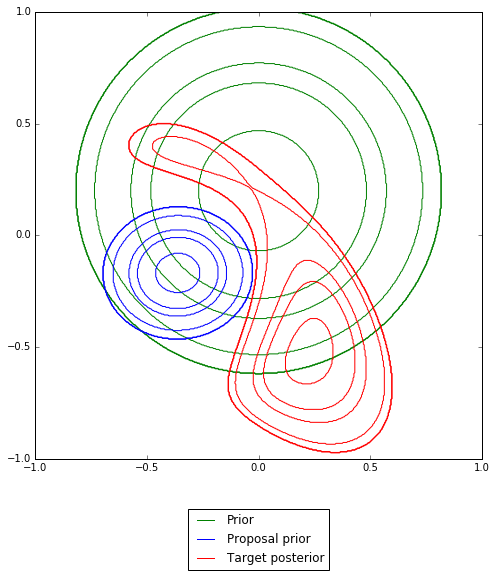

In [78]:
# visualize results
res = 500
xlims = (-params.x_width, params.x_width)
ylims = xlims

xaxis = np.linspace(*xlims, res)
yaxis = np.linspace(*ylims, res)
x, y = np.meshgrid(xaxis, yaxis)

xy = np.concatenate([x.reshape([-1, 1]), 
                     y.reshape([-1, 1])], 
                    axis=1)


levels = [0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

prior_contour = probs2contours(params.prior.eval(xy, log=False), levels).reshape(res, res)
prop_contour = probs2contours(params.prop.eval(xy, log=False), levels).reshape(res, res)

plt.figure(figsize=(8, 8))

plt.contour(x, y, prior_contour, colors=('g'))
plt.contour(x, y, prop_contour, colors=('b'))

if params.target is not None:
    target_contour = probs2contours(params.target.eval(xy, log=False), levels).reshape(res, res)
    plt.contour(x, y, target_contour, colors=('r'))

green_line = mlines.Line2D([], [], color='g', label='Prior')
blue_line = mlines.Line2D([], [], color='b', label='Proposal prior')
red_line = mlines.Line2D([], [], color='r', label='Target posterior')
plt.legend(handles=[green_line, blue_line, red_line], 
           loc=9, bbox_to_anchor=(0.5, -0.1))

plt.show()

In [64]:
pickle.dump(params, open('example_mog.pkl', 'wb'))

In [65]:
params.target.get_mass((-5,5))

1.0049848417427885

In [66]:
params

{'dirichlet_alpha': 0.5,
 'dof': 12,
 'n_comps': 2,
 'n_prop_comps': 1,
 'ndim': 2,
 'prior': <delfi.distribution.Gaussian.Gaussian at 0x7f4f26d48208>,
 'prior_mixin': 0.3,
 'prior_width': 0.5,
 'prop': <delfi.distribution.mixture.GaussianMixture.MoG at 0x7f4f26d48ba8>,
 'prop_scale': 1,
 'scale': 0.7,
 'target': <mogtrain.DividedPdf at 0x7f4f26d48e10>,
 'uncorrected': <delfi.distribution.mixture.GaussianMixture.MoG at 0x7f4f26d48a20>,
 'x_width': 1}

In [67]:
params.prior

In [73]:
diff = [ 0, 0.2 ]

In [74]:
params.prior.m += diff

In [75]:
for x in params.prop.xs:
    x.m += diff

In [76]:
for x in params.uncorrected.xs:
    x.m += diff

In [77]:
mixture = DefensiveDistribution(params.prop, params.prior, alpha=params.prior_mixin)
params.target = divide_dists(params.uncorrected * params.prior, mixture, (-params.x_width * 5, params.x_width * 5))